In [1]:
from pathlib import Path
import glob
import os
import config as cfg
import numpy as np
import pandas as pd

from utility.plot import map_model_name

matplotlib_style = 'default'
import matplotlib.pyplot as plt; plt.style.use(matplotlib_style)
plt.rcParams.update({'axes.labelsize': 'medium',
                     'axes.titlesize': 'medium',
                     'font.size': 14.0,
                     'text.usetex': True,
                     'text.latex.preamble': r'\usepackage{amsfonts} \usepackage{bm}'})

N_DECIMALS = 2
ALPHA = 0.05

path = Path.joinpath(cfg.RESULTS_DIR, f"model_results.csv")
df = pd.read_csv(path)
df = df.round(N_DECIMALS).fillna(0)

dataset_name = "proact"
model_names = ['coxph', 'rsf', 'deepsurv', 'mtlr', 'mensa']
metric_names = ["MAEM"]

from utility.plot import load_tf_color
TFColor = load_tf_color()

In [2]:
# Calculate KM means
km_mean = list(df.groupby('EventId')['MAEKM'].mean())

In [3]:
model_results = dict()
for model_name in model_names:
    results = df.loc[(df['ModelName'] == model_name) & (df['DatasetName'] == dataset_name)][['EventId', 'Seed', 'MAEM']]
    results_pivot = results.pivot(index='Seed', columns='EventId', values='MAEM')
    #results_pivot = results_pivot[[1, 2, 3, 4]]
    model_results[model_name] = results_pivot

In [4]:
from scipy import stats

def calculate_ci(x):
    return stats.sem(x) * stats.t.ppf((1 + 0.95) / 2., len(x) - 1)

# Calculate means and confidence intervals for each model
means, errors = [], []
for model_name in model_names:
    means_C0 = model_results[model_name].mean(axis=0)
    conf_intervals_C0 = model_results[model_name].apply(calculate_ci, axis=0)
    means.append(means_C0)
    errors.append(conf_intervals_C0)

c:\Users\cml\miniconda3\envs\py39-als\lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\cml\miniconda3\envs\py39-als\lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [5]:
means_arr = np.array(means).T
errors_arr = np.array(errors).T

c:\Users\cml\miniconda3\envs\py39-als\lib\site-packages\matplotlib\axes\_axes.py:1185: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
c:\Users\cml\miniconda3\envs\py39-als\lib\site-packages\matplotlib\axes\_axes.py:1186: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])


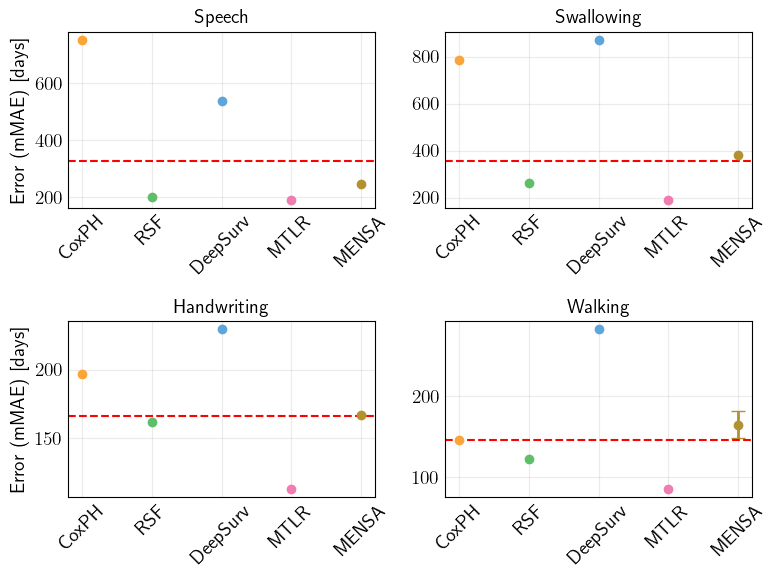

In [6]:
x_pos = np.arange(len(model_names))
model_display_names = mapped_names = [map_model_name(name) for name in model_names]
fig, axes = plt.subplots(2, 2, figsize=(8, 6))
event_names = ['Speech', 'Swallowing', 'Handwriting', 'Walking']

for i, ax in enumerate(axes.flatten()):
    for j in range(len(model_names)):  # Loop through each model
            ax.errorbar(x_pos[j], means_arr[i][j], yerr=errors_arr[i][j], 
                        fmt='o', elinewidth=2, capsize=5, color=TFColor[j+1])
    ax.set_title(event_names[i], weight="bold")
    ax.set_xticks(x_pos)
    ax.set_xticklabels(model_display_names, rotation=45)
    ax.grid(True, alpha=0.25)
    
    ax.tick_params(axis='y', which='both', length=0)
    ax.tick_params(axis='x', which='both', length=0)
    
    if i % 2 == 0:
        ax.set_ylabel('Error (mMAE) [days]', fontweight='bold')

    ax.axhline(km_mean[i], color='red', linestyle='--')

plt.tight_layout()
plt.savefig(f"{cfg.PLOTS_DIR}/{dataset_name}_model_vs_km.pdf", format='pdf', bbox_inches='tight')
plt.show()